In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from utils import *
import os

In [2]:
base_folder_path = 'MIVIA_HEp-2_Images_Dataset/Main_Dataset/Cells/Cell_Images/01'

In [3]:
file_path = 'MIVIA_HEp-2_Images_Dataset/Main_Dataset/Cells/Cell_Images/01/001.png'
cell_image = Image.open(file_path)

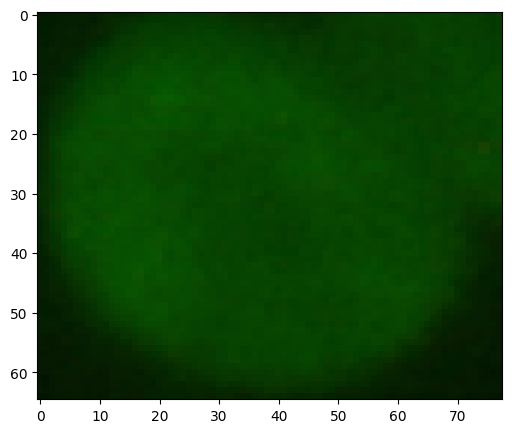

In [4]:
plt.figure(figsize=(6, 6))
plt.imshow(cell_image)
plt.show()

In [5]:
cell_image.size

(78, 65)

In [6]:
np_cell = np.array(cell_image)

In [7]:
np_cell.shape

(65, 78, 3)

In [8]:
np_cell[:,:,0].shape # Segregating first channel of the image

(65, 78)

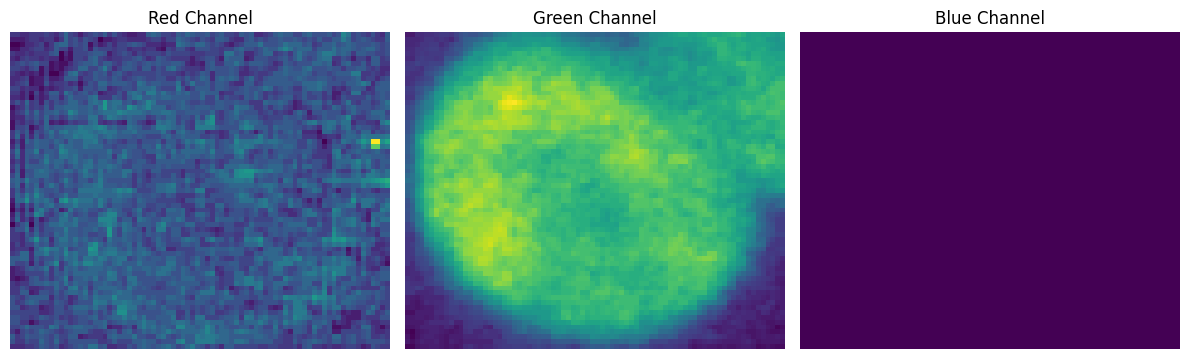

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot each channel
axes[0].imshow(np_cell[:,:,0])
axes[0].set_title('Red Channel')
axes[0].axis('off')

axes[1].imshow(np_cell[:,:,1])
axes[1].set_title('Green Channel')
axes[1].axis('off')

axes[2].imshow(np_cell[:,:,2])
axes[2].set_title('Blue Channel')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Converting to YCBCR

ycbcr_cell = cell_image.convert('YCbCr')
y, cb, cr = ycbcr_cell.split()

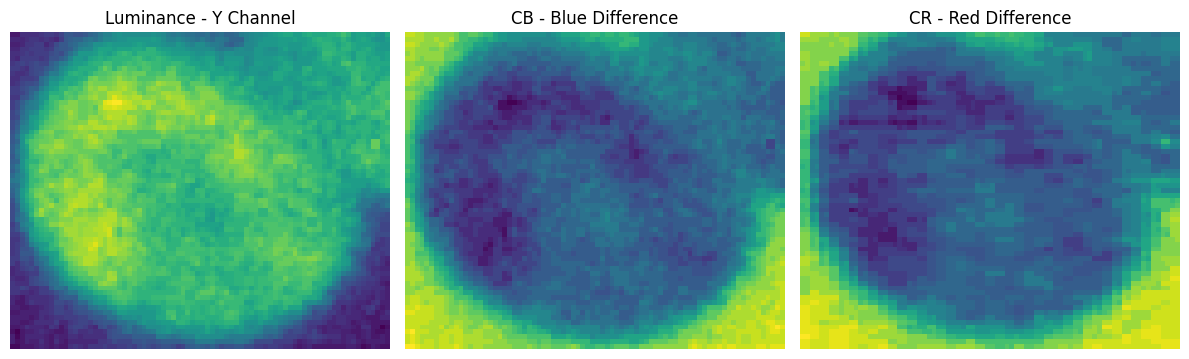

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot each channel
axes[0].imshow(y)
axes[0].set_title('Luminance - Y Channel')
axes[0].axis('off')

axes[1].imshow(cb)
axes[1].set_title('CB - Blue Difference')
axes[1].axis('off')

axes[2].imshow(cr)
axes[2].set_title('CR - Red Difference')
axes[2].axis('off')

plt.tight_layout()
plt.show()

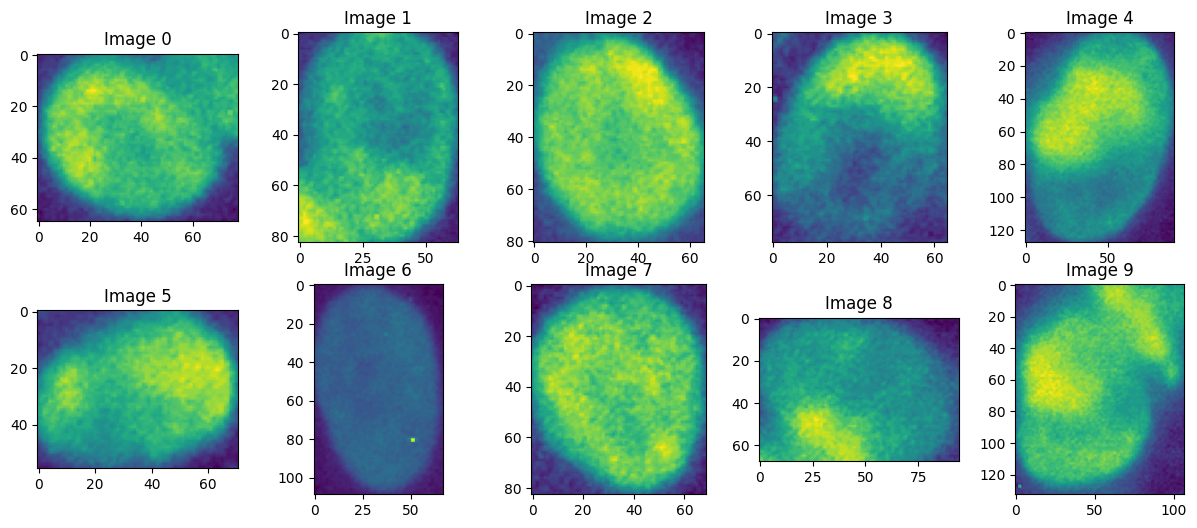

In [21]:
"""
    According to Nosaka's paper, the luminance of a HEp-2 cell image is often unstable.
    So, Let's see some pictures of the luminance channel of the cells.
    We Can see that is indeed true. 

"""

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for idx in range(0, 10):
    # Format the filename
    image_file = f'{idx+1:03}.png'  # Creates filenames like '001.png', '002.png', ..., '010.png'
    image_path = os.path.join(base_folder_path, image_file)
    y_channel = getYCbCr(image_path)
    i = idx // 5  # Row index
    j = idx % 5

    axs[i, j].imshow(y_channel)
    axs[i, j].set_title(f'Image {idx}')

In [45]:
import numpy as np
from skimage.feature import local_binary_pattern as lbp

def LBP(image, points=8, radius=1):
    '''
    Uniform Local Binary Patterns algorithm
    Input image with shape (height, width, channels)
    Output features with length * number of channels
    '''
    # calculate pattern length
    length = points**2 - abs(points - 3)
    # lbp per channel in image
    histogram = np.empty(0, dtype=np.int64)
    for i in range(image.shape[2]):
        channel = image[:, :, i]
        pattern = lbp(channel, points, radius, method='nri_uniform')
        pattern = pattern.astype(np.int64).ravel()                      # returns a flatten array
        pattern = np.bincount(pattern)                                  # return count of every pattern
        
        if len(pattern) < length:
            pattern = np.concatenate((pattern, np.zeros(59 - len(pattern))))
        histogram = np.concatenate((histogram, pattern))
    # normalize the histogram and return it
    features = (histogram - np.mean(histogram)) / np.std(histogram)
    return features

In [51]:
LBP(np_cell).shape

(177,)

(array([173.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.23033615,  1.05305873,  2.33645361,  3.61984849,  4.90324338,
         6.18663826,  7.47003314,  8.75342802, 10.0368229 , 11.32021779,
        12.60361267]),
 <BarContainer object of 10 artists>)

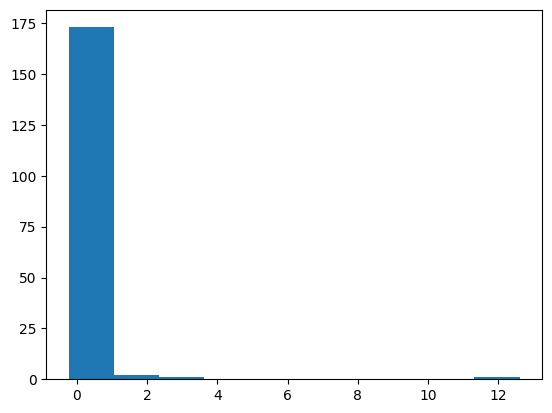

In [38]:
plt.hist(LBP(np_cell))

In [35]:
LBP(np_cell).shape

(177,)

In [52]:
def CoALBP(image, lbp_r=1, co_r=2):
    '''
    Co-occurrence of Adjacent Local Binary Patterns algorithm 
    Input image with shape (height, width, channels)
    Input lbp_r is radius for adjacent local binary patterns
    Input co_r is radius for co-occurence of the patterns
    Output features with length 1024 * number of channels
    '''
    h, w, c = image.shape
    # normalize face
    image = (image - np.mean(image, axis=(0,1))) / (np.std(image, axis=(0,1)) + 1e-8)
    # albp and co-occurrence per channel in image
    histogram = np.empty(0, dtype=np.int)
    for i in range(image.shape[2]):
        C = image[lbp_r:h-lbp_r, lbp_r:w-lbp_r, i].astype(float)
        X = np.zeros((4, h-2*lbp_r, w-2*lbp_r))
        # adjacent local binary patterns
        X[0, :, :] = image[lbp_r  :h-lbp_r  , lbp_r+lbp_r:w-lbp_r+lbp_r, i] - C
        X[1, :, :] = image[lbp_r-lbp_r:h-lbp_r-lbp_r, lbp_r  :w-lbp_r  , i] - C
        X[2, :, :] = image[lbp_r  :h-lbp_r  , lbp_r-lbp_r:w-lbp_r-lbp_r, i] - C
        X[3, :, :] = image[lbp_r+lbp_r:h-lbp_r+lbp_r, lbp_r  :w-lbp_r  , i] - C
        X = (X>0).reshape(4, -1)
        # co-occurrence of the patterns
        A = np.dot(np.array([1, 2, 4, 8]), X)
        A = A.reshape(h-2*lbp_r, w-2*lbp_r) + 1
        hh, ww = A.shape
        D  = (A[co_r  :hh-co_r  , co_r  :ww-co_r  ] - 1) * 16 - 1
        Y1 =  A[co_r  :hh-co_r,   co_r+co_r:ww-co_r+co_r] + D
        Y2 =  A[co_r-co_r:hh-co_r-co_r, co_r+co_r:ww-co_r+co_r] + D
        Y3 =  A[co_r-co_r:hh-co_r-co_r, co_r  :ww-co_r  ] + D
        Y4 =  A[co_r-co_r:hh-co_r-co_r, co_r-co_r:ww-co_r-co_r] + D
        Y1 = np.bincount(Y1.ravel(), minlength=256)
        Y2 = np.bincount(Y2.ravel(), minlength=256)
        Y3 = np.bincount(Y3.ravel(), minlength=256)
        Y4 = np.bincount(Y4.ravel(), minlength=256)
        pattern = np.concatenate((Y1, Y2, Y3, Y4))
        histogram = np.concatenate((histogram, pattern))
    # normalize the histogram and return it
    features = (histogram - np.mean(histogram)) / np.std(histogram)
    return features

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

In [2]:
import pandas as pd

# Load the CSV file
csv_file_path = 'C:/Users/TANISHQ/Documents/GitHub/HEp2-Cell-Classification-Survey/MIVIA_HEp-2_Images_Dataset/ICPR2012_Cells_Classification_Contest/cells.csv'  # Change this to your CSV file path
data = pd.read_csv(csv_file_path, sep=";")  # Use sep=';' to handle the semicolon delimiter

data


,ICPR2012Contest_Cell_ID,Set,Image,Intensity,Original_cell_ID,Cell_class,Cell_width,Cell_height
0,1,training,18,positive,30,homogeneous,67,98
1,2,training,6,positive,14,coarse_speckled,83,76
2,3,training,1,positive,54,homogeneous,94,80
3,4,training,8,positive,25,nucleolar,96,72
4,5,training,8,positive,32,nucleolar,82,83
...,...,...,...,...,...,...,...,...
1450,730,test,22,positive,48,homogeneous,74,82
1451,731,test,27,positive,17,cytoplasmatic,78,209
1452,732,test,24,positive,47,nucleolar,85,97
1453,733,test,27,positive,43,cytoplasmatic,78,91


In [3]:
# Separate the data into training and testing sets
training_data = data[data['Set'] == 'training']
testing_data = data[data['Set'] == 'test']

# Display the shapes of the training and testing sets
print("Training data shape:", training_data.shape)
print("Testing data shape:", testing_data.shape)

# Example of accessing specific columns
training_images = training_data['ICPR2012Contest_Cell_ID'].tolist()  # List of training images
training_classes = training_data['Cell_class'].tolist()  # List of cell classes for training images

testing_images = testing_data['ICPR2012Contest_Cell_ID'].tolist()  # List of testing images
testing_classes = testing_data['Cell_class'].tolist()  # List of cell classes for testing images

# Display the lists
print("Training images:", training_images)
print("Training classes:", training_classes)
print("Testing images:", testing_images)
print("Testing classes:", testing_classes)


Training data shape: (721, 8)
Testing data shape: (734, 8)
Training images: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 2

In [4]:
training_path = "C:\\Users\\TANISHQ\\Documents\\GitHub\\HEp2-Cell-Classification-Survey\\MIVIA_HEp-2_Images_Dataset\\ICPR2012_Cells_Classification_Contest\\training"
testing_path = "C:\\Users\\TANISHQ\\Documents\\GitHub\\HEp2-Cell-Classification-Survey\\MIVIA_HEp-2_Images_Dataset\\ICPR2012_Cells_Classification_Contest\\test"

In [5]:
def load_images(main_folder, images, classes):
    img_data = []
    labels = []
    for i in range(len(images)):  # Folders are numbered from 01 to 28
        folder_path = os.path.join(main_folder, f'{images[i]:03d}.png')
        class_label = classes[i]  # Map the folder to the appropriate class
        # print(folder_path, string_to_label(class_label), class_label)
        # img_path = os.path.join(folder_path, img_name)
        # for img_name in os.listdir(folder_path):
        img = Image.open(folder_path)
        # img = img.resize((28, 28))  # Resize to a fixed size
        img_array = np.array(img)
        # img = img.filter(ImageFilter.GaussianBlur(radius=1))
        # img_array = img_array.flatten()
        img_data.append(img_array)
        labels.append(class_label)
        # labels.append(string_to_label(class_label))
    return img_data, labels
          # Convert to grayscale

In [6]:
training_data, training_labels = load_images(training_path, training_images, training_classes)
testing_data, testing_labels = load_images(testing_path, testing_images, testing_classes)

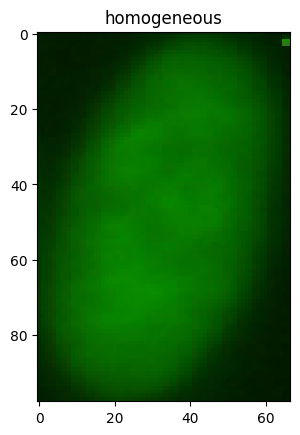

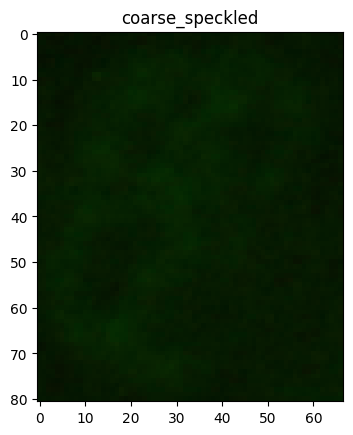

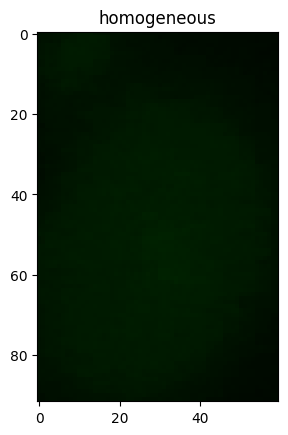

In [7]:
import matplotlib.pyplot as plt
plt.imshow(training_data[0])
plt.title(training_classes[0])
plt.show()
plt.imshow(training_data[10])
plt.title(training_classes[10])
plt.show()
plt.imshow(training_data[20])
plt.title(training_classes[20])
plt.show()

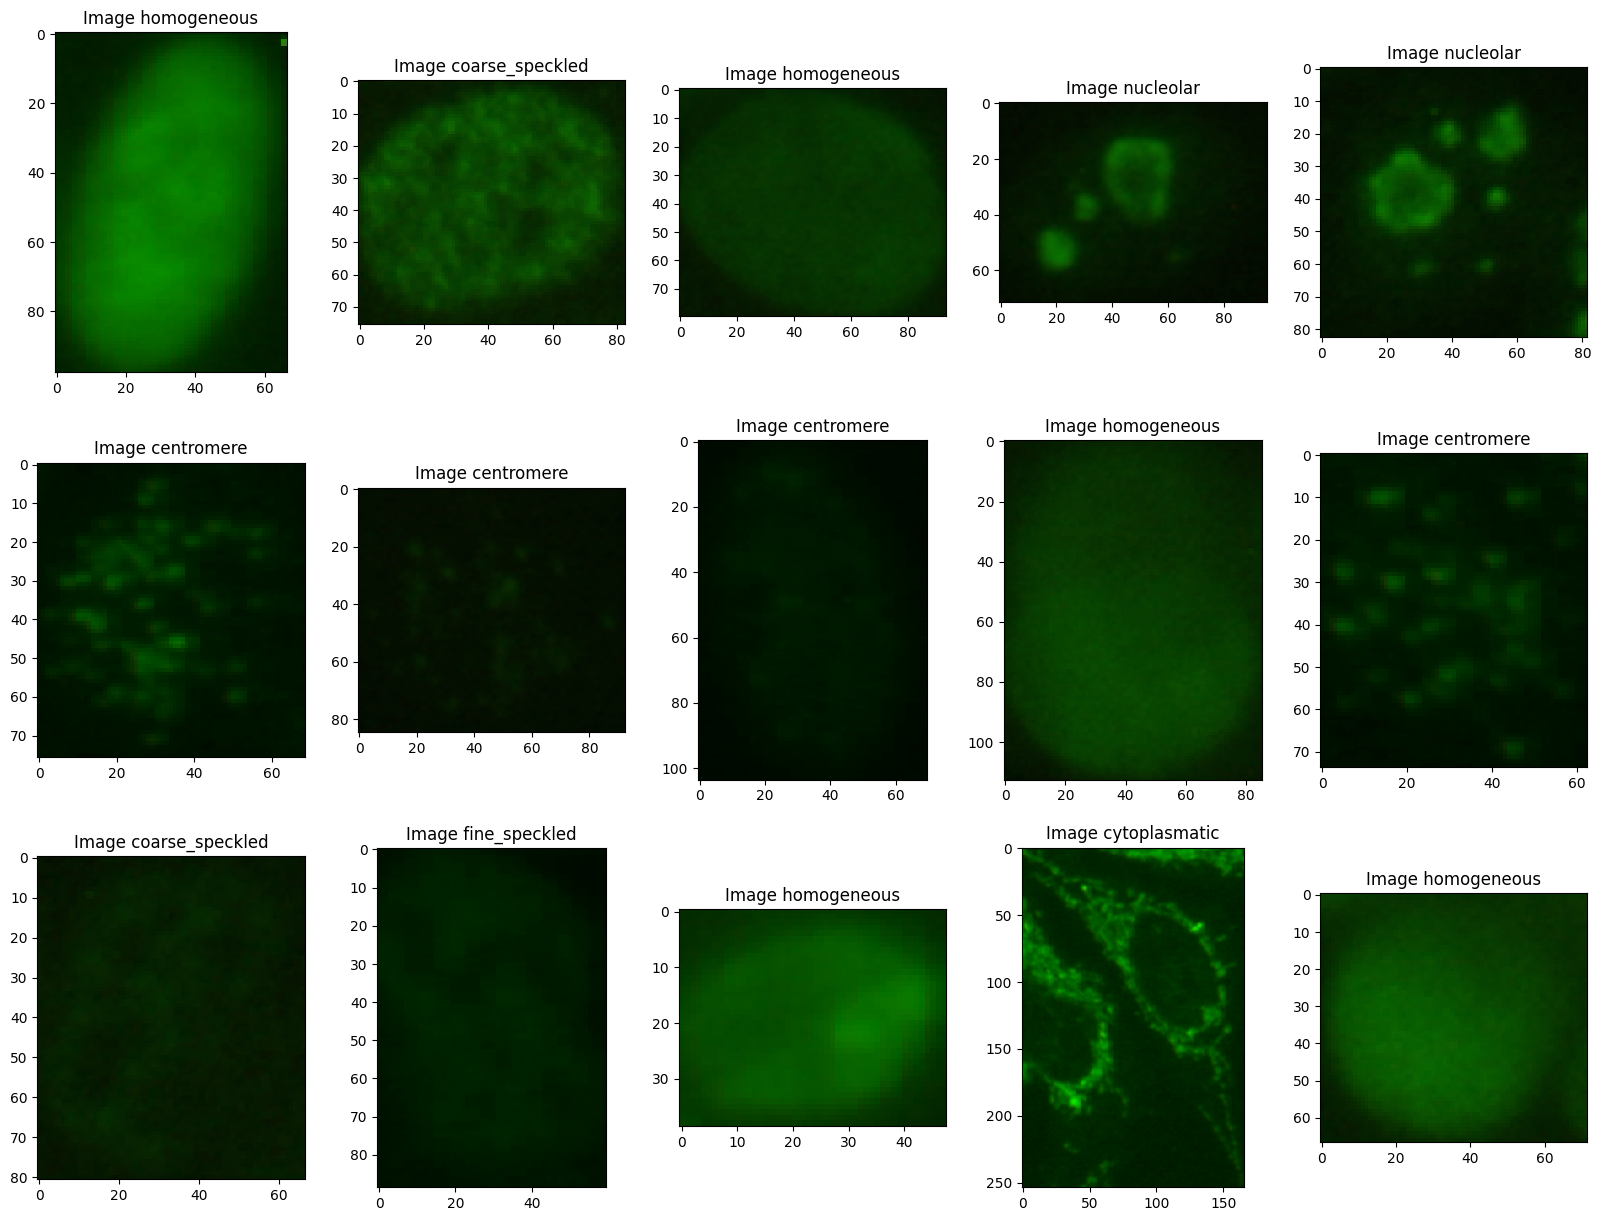

In [8]:
fig, axs = plt.subplots(3, 5, figsize=(20, 15))
for idx in range(15):
    # Format the filename
    # image_file = f'{idx+1:03}.png'  # Creates filenames like '001.png', '002.png', ..., '010.png'
    # image_path = os.path.join(base_folder_path, image_file)
    # y_channel = getYCbCr(image_path)
    i = idx // 5  # Row index
    j = idx % 5

    axs[i, j].imshow(training_data[idx])
    axs[i, j].set_title(f'Image {training_classes[idx]}')

In [18]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set up paths
dataset_dir = 'ICPR_HEp2016'
train_dir = 'ICPR_HEp2016/train'
test_dir = 'ICPR_HEp2016/test'

# Create directories for train and test if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to move images
# def move_images(dataset_dir, train_dir, test_dir, test_ratio=0.2):
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    # print(class_path)
    if os.path.isdir(class_path):
    #     # Get all cell image file paths (not mask images)
        cell_images = [os.path.join(class_path, img) for img in os.listdir(class_path) 
                        if img.endswith(('png', 'jpg', 'jpeg')) and '_mask' not in img]
        if(len(cell_images) != 0):
            for image_path in cell_images:
                
                if("Mask" not in image_path):
                    print(image_path, f'{dataset_dir}/whole/{class_name}_{os.path.basename(image_path)}')
                    shutil.copy2(image_path, f'{dataset_dir}/whole/{class_name}_{os.path.basename(image_path)}')


ICPR_HEp2016\Centromere\07924.png ICPR_HEp2016/whole/Centromere_07924.png
ICPR_HEp2016\Centromere\07925.png ICPR_HEp2016/whole/Centromere_07925.png
ICPR_HEp2016\Centromere\07926.png ICPR_HEp2016/whole/Centromere_07926.png
ICPR_HEp2016\Centromere\07927.png ICPR_HEp2016/whole/Centromere_07927.png
ICPR_HEp2016\Centromere\07928.png ICPR_HEp2016/whole/Centromere_07928.png
ICPR_HEp2016\Centromere\07929.png ICPR_HEp2016/whole/Centromere_07929.png
ICPR_HEp2016\Centromere\07930.png ICPR_HEp2016/whole/Centromere_07930.png
ICPR_HEp2016\Centromere\07931.png ICPR_HEp2016/whole/Centromere_07931.png
ICPR_HEp2016\Centromere\07932.png ICPR_HEp2016/whole/Centromere_07932.png
ICPR_HEp2016\Centromere\07933.png ICPR_HEp2016/whole/Centromere_07933.png
ICPR_HEp2016\Centromere\07934.png ICPR_HEp2016/whole/Centromere_07934.png
ICPR_HEp2016\Centromere\07935.png ICPR_HEp2016/whole/Centromere_07935.png
ICPR_HEp2016\Centromere\07936.png ICPR_HEp2016/whole/Centromere_07936.png
ICPR_HEp2016\Centromere\07937.png ICPR